# <center> Meucci's Framework Aggregated</center>

&copy; Kaiwen Zhou 2023

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import cvxopt 

from datetime import timedelta
import impyute as impy
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Load data

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the list of top 8 stocks in different industries (use their Yahoo Finance ticker symbols)
stocks = ['AAPL', 'AMZN', 'JPM', 'JNJ', 'XOM', 'GE', 'HD']

# Define the date range
start_date = '2012-01-08'
end_date = '2022-12-31'

# Fetch the weekly stock data
stock_data = {}
for stock in stocks:
    stock_data[stock] = yf.download(stock, start=start_date, end=end_date, interval='1wk')

# Extract the weekly closing prices
weekly_closing_prices = pd.DataFrame()

for stock, data in stock_data.items():
    weekly_closing_prices[stock] = data['Close']

# Save the weekly closing prices to a CSV file
weekly_closing_prices.to_csv('weekly_closing_prices_2012_2022.csv', index=True)

df_data = weekly_closing_prices
print("Weekly closing prices from 2012 to 2022 for the top 7 stocks in different industries:")
df_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Weekly closing prices from 2012 to 2022 for the top 7 stocks in different industries:


,AAPL,AMZN,JPM,JNJ,XOM,GE,HD
Date,,,,,,,
2012-01-09,14.993214,8.921000,35.919998,65.260002,84.879997,113.132767,43.509998
2012-01-16,15.010714,9.546500,37.360001,65.269997,87.489998,114.994293,44.509998
2012-01-23,15.974286,9.768500,37.209999,65.559998,85.830002,114.273705,44.869999
2012-01-30,16.417143,9.384000,38.279999,65.639999,84.919998,114.213654,45.169998
2012-02-06,17.622143,9.277000,37.610001,64.599998,83.800003,113.372963,45.330002
...,...,...,...,...,...,...,...
2022-11-28,147.809998,94.129997,135.160004,178.880005,109.860001,67.822014,327.989990
2022-12-05,142.160004,89.089996,132.160004,175.740005,103.540001,63.583138,320.480011
2022-12-12,134.509995,87.860001,129.289993,175.669998,104.699997,60.616707,323.339996


# Specify Investor's Profile

As the investor, we have a few things to set at the first place. They are:
- Initial wealth
- Estimation horizion $\widetilde{\tau}$
- Investment horizon $\tau$
- Investor's Objectives
- Index of Satisfaction

Now, we tackle each of them.

### Initial Wealth

This could be any number; however, it has significant impact on the optimal allocations. Here, we just put initial wealth =1000 as a place holder.

In [3]:
initial_wealth = 1000

### Estimation horizion & Investment horizon 

Let's suppose estimation $\widetilde{\tau}=1$ week and investment horizon is $\tau=3$ week

In [4]:
τ_estimate= 1 # estimation horizon
τ_horizon = 3 # investment horizon

### Investor's Objectives

This is pretty important as it directly affect the allocation scheme. What we have to do is just calculate the mean of $\mathbf{M}$ and the covariance of $\mathbf{M}$.

In [5]:
def investor_objective(P_mean : 'ndarray'=None , P_Cov : 'ndarray'=None, obj_type : 'string'=None, **kwarg) -> ('ndarray','ndarray'):
    
    #  To make it compatible with the case where P_mean is in shape (1,n) or (n, 1)
    P_mean=P_mean.squeeze()
    #  Get the number of asset we are dealing with
    num_asset = P_mean.shape[0]
    
    ####### Absolute Wealth
    if obj_type == 'absolute wealth' or obj_type == 'final wealth':
        a=np.zeros(num_asset)
        B=np.eye(num_asset)
        
    ####### Relative Wealth   
    elif obj_type == 'relative wealth':
        # Getting current price and benchmark allocation from **kwarg
        for key, value in kwargs.items():
            if key=='α_benchmark':
                α_benchmark=value
            if key=='P_current':
                P_current=value
        a=np.zeros(num_asset)
        B=np.eyes(num_asset)-P_current.T@α_benchmark/α_benchmark.T@P_current
    
    ####### Net Profits 
    elif obj_type == 'net profits':
        # Getting current price from **kwarg
        for key, value in kwargs.items():
            if key=='P_current':
                P_current=value
        a=-P_current
        B=np.eyes(num_asset)
    
    #  Find the corresponding mean and covariance for M
    M_mean = a+B@P_mean
    M_Cov = B@P_Cov@B.T
    return M_mean, M_Cov

### Index of Satisfaction

This is the criteria for us to choose the optimal allocation among all allocations on the effecient frontier, an analog to the risk reversion coefficient as in the classical MVO framework.

In [6]:
def certainty_equivalent(λ, α_optimal,μ_P_logN,Σ_P_logN, N_MC):
    np.random.seed(66)
    sum_Ψ=0
    for P_j in np.exp(np.random.multivariate_normal(μ_P_logN.squeeze(),Σ_P_logN, N_MC)):
        #print(P_j)
        sum_Ψ += (P_j@α_optimal)**((λ-1)/λ)
    return (sum_Ψ/N_MC)**(λ/(λ-1))

# Modeling the market

Sometimes there maybe some missing values in our time series data, and we have to use some method to recover it. Here we introduce the EM algorithm to do that. However, we can always use more ad hoc way to do it like imputing as the price the day before, etc.

## Market Information

Given the raw data that we loaded, we should first speciffy the part of raw data that will be used for estimation. Then, we find the market information such as:
- number of assets
- current price for all assets
- transaction cost
- time series for invariants
- Estimation for the distribution of invariants
- Projection onto the investment horizon

In [7]:
date_start_estimation = pd.to_datetime('2012-01-09')  # first considered date
date_end_estimation = pd.to_datetime('2017-01-02')  # last date for estimation as well as the current time T

# market data for esimation period: \tilde{t} to T
Market_data_estimate = df_data[(df_data.index >= date_start_estimation) & (df_data.index <= date_end_estimation)].values
Market_data_estimate, Market_data_estimate.shape

(array([[ 14.99321365,   8.92099953,  35.91999817, ...,  84.87999725,
         113.13276672,  43.50999832],
        [ 15.01071358,   9.54650021,  37.36000061, ...,  87.48999786,
         114.99429321,  44.50999832],
        [ 15.97428608,   9.76850033,  37.20999908, ...,  85.83000183,
         114.27370453,  44.86999893],
        ...,
        [ 29.12999916,  38.02949905,  87.05000305, ...,  90.70999908,
         191.4369812 , 135.05000305],
        [ 28.95499992,  37.49349976,  86.29000092, ...,  90.26000214,
         189.75559998, 134.08000183],
        [ 29.47750092,  39.79949951,  86.12000275, ...,  88.5       ,
         189.81564331, 133.52999878]]),
 (261, 7))

In [8]:
# number of assets
N_assets = Market_data_estimate.shape[1]
# number of observations
Market_data_estimate.shape[0]

# Prices of asset at current time T
P_T = Market_data_estimate[-1:].squeeze()
P_T.shape

(7,)

This transaction cost is when you don't have a inital holding but only initial wealth.

In [9]:
D = np.eye(N_assets)*0.01

# Get Invariants

In [10]:
# Get market invariants for each asset
invariants = np.diff(np.log(Market_data_estimate), axis=0)
print(f'In total, we have {invariants.shape[1]} different invariants for {N_assets} different assets, and we have {invariants.shape[0]} samples for each asset\'s invariant.')

In total, we have 7 different invariants for 7 different assets, and we have 260 samples for each asset's invariant.


### Sanity Check: Split Plot

We split the invariants for one of the assets in half and plot both histograms. By the definition of invariants, the two histograms should look somewhat alike.

In [11]:
pick_index = np.random.choice(range(N_assets))
invariants_split_plot = invariants[:, pick_index]
half_point = int(invariants.shape[0]/2)
pick_index, half_point

(1, 130)

(array([ 2.,  4.,  2.,  7.,  9., 10., 20., 13., 13., 12., 11.,  9.,  8.,
         5.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.07751535, -0.06731992, -0.0571245 , -0.04692908, -0.03673365,
        -0.02653823, -0.01634281, -0.00614739,  0.00404804,  0.01424346,
         0.02443888,  0.0346343 ,  0.04482973,  0.05502515,  0.06522057,
         0.07541599,  0.08561142,  0.09580684,  0.10600226,  0.11619769,
         0.12639311,  0.13658853,  0.14678395,  0.15697938,  0.1671748 ,
         0.17737022]),
 <BarContainer object of 25 artists>)

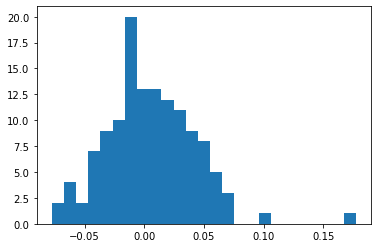

In [12]:
plt.hist(invariants_split_plot[:half_point], bins=25)

(array([ 1.,  0.,  0.,  1.,  1.,  1.,  1.,  5.,  3.,  7., 20., 16., 19.,
        19., 13.,  9.,  8.,  1.,  2.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([-0.15616576, -0.1431239 , -0.13008204, -0.11704018, -0.10399832,
        -0.09095647, -0.07791461, -0.06487275, -0.05183089, -0.03878903,
        -0.02574717, -0.01270532,  0.00033654,  0.0133784 ,  0.02642026,
         0.03946212,  0.05250397,  0.06554583,  0.07858769,  0.09162955,
         0.10467141,  0.11771327,  0.13075512,  0.14379698,  0.15683884,
         0.1698807 ]),
 <BarContainer object of 25 artists>)

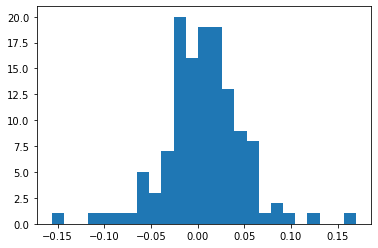

In [13]:
plt.hist(invariants_split_plot[half_point:], bins=25)

### Sanity Check: Lag-Plot

It's should look like the multivariate normal distribution.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

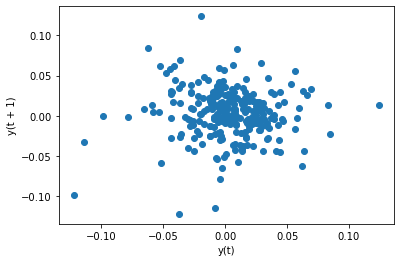

In [14]:
# Lag-Plot all the samples for one of the asset's invariant
# We should see a roughly normally distributed dataset
pd.plotting.lag_plot(pd.Series(invariants[:,2]), lag=1)

# Estimate the distribution of invariants

## Different Estimators

### Sample Estimators

$$
\widehat{\mathbf{m}} \equiv \frac{1}{T} \sum_{t=1}^T \mathbf{c}_{t, \tilde{\tau}}, \quad \widehat{\mathbf{S}} \equiv \frac{1}{T} \sum_{t=1}^T\left(\mathbf{c}_{t, \tilde{\tau}}-\widehat{\mathbf{m}}\right)\left(\mathbf{c}_{t, \tilde{\tau}}-\widehat{\mathbf{m}}\right)^{\top} .
$$

In [15]:
def cal_mean_cov(ndarray: np.ndarray):
    '''
    Input: ndarray where each column represents the total samples for each invariant
    
    Sample mean and sample covariance
    '''
    #  compute the mean
    mean = np.mean(ndarray, axis=0)
    #  compute the covariance
    cov = (1/ndarray.shape[0])*np.matmul((ndarray-mean).T, (ndarray-mean))
    
    return mean, cov

Suppose we have the sample mean and the sample covariance matrix:
$$
\widehat{\mathbf{m}} \equiv \frac{1}{T} \sum_{t=1}^T \mathbf{c}_{t, \tilde{\tau}}, \quad \widehat{\mathbf{S}} \equiv \frac{1}{T} \sum_{t=1}^T\left(\mathbf{c}_{t, \tilde{\tau}}-\widehat{\mathbf{m}}\right)\left(\mathbf{c}_{t, \tilde{\tau}}-\widehat{\mathbf{m}}\right)^{\top} .
$$
 We then shrink the covariance matrix toward a spherical estimator:
$$
\widehat{\mathbf{\Sigma}} \equiv(1-\epsilon) \widehat{\mathbf{S}}+\frac{\epsilon}{N} \sum_{n=1}^N \widehat{S}_{n n} \mathbf{I}_N
$$
where from  the shrinkage weight reads:
$$
\epsilon \equiv \frac{1}{T} \frac{\frac{1}{T} \sum_{t=1}^T \operatorname{tr}\left\{\left(\mathbf{c}_{t, \tilde{\tau}} \mathbf{c}_{t, \tilde{\tau}}^{\top}-\widehat{\mathbf{S}}\right)^2\right\}}{\operatorname{tr}\left\{\left(\widehat{\mathbf{S}}-\frac{1}{N} \sum_{n=1}^N \widehat{S}_{n n} \mathbf{I}_N\right)^2\right\}}
$$
Finally, we shrink the sample mean towards a target vector:
$$
\widehat{\boldsymbol{\mu}} \equiv(1-\gamma) \widehat{\mathbf{m}}+\gamma \mathbf{b}
$$
In this expression the shrinkage target follows from:
$$
\mathbf{b} \equiv \frac{\mathbf{1}^{\top} \widehat{\mathbf{\Sigma}}^{-1} \widehat{\mathbf{m}}}{\mathbf{1}^{\top} \widehat{\mathbf{\Sigma}}^{-1} \mathbf{1}} \mathbf{1}, \quad \gamma \equiv \frac{1}{T} \frac{\sum_{n=1}^N \widehat{\Sigma}_{n n}-2 \lambda_1}{(\widehat{\mathbf{m}}-\mathbf{b})^{\top}(\widehat{\mathbf{m}}-\mathbf{b})}
$$
where $\lambda_1$ is the highest eigenvalue of $\widehat{\Sigma}$.

In [16]:
def shrinkage_mean_cov(ndarray: 'np.array'):
    """
    Input: ndarray where each column represents the total samples for each invariant

    Sample mean and sample covariance
    """
    # number of observations
    N_obs = ndarray.shape[0]
    # number of invariants 
    N_invariants = ndarray.shape[1]
    
    #  compute the mean
    mean = np.mean(ndarray, axis=0)
    #  compute the covariance
    cov = (1/ndarray.shape[0])*np.matmul((ndarray-mean).T, (ndarray-mean))
    
    ########### Get shrinkage covariance
    # Compute epsilon
    numerator = 0
    for i in range(N_obs):
        numerator += np.trace((ndarray[i, :]@ndarray[i, :].T - cov)@(ndarray[i, :]@ndarray[i, :].T - cov))/N_obs
        
    denominator = 0
    for i in range(N_invariants):
        denominator += np.trace((cov-np.eye(N_invariants)*(cov[i, i]/N_invariants))@(cov-np.eye(N_invariants)*(cov[i, i]/N_invariants)))
    
    epsilon = (1/N_obs) * numerator/denominator
    
    cov_shrinkage = (1-epsilon)*cov + (epsilon/N_invariants)*np.trace(cov)*np.eye(N_invariants)
    
    ########### Get shrinkage mean
    e = np.ones(N_invariants)
    b = (e.T@np.linalg.inv(cov_shrinkage)@mean / (e.T@np.linalg.inv(cov_shrinkage)@e))*e
    largest_eigenvalue = np.amax(np.linalg.eigvals(cov_shrinkage))
    gamma = (np.trace(cov_shrinkage)-2*largest_eigenvalue)/((mean-b).T@(mean-b))/N_obs
    
    mean_shrinkage = (1-gamma)*mean + gamma*b
    return mean_shrinkage, cov_shrinkage

In [17]:
# estimate sample mean and sample covariance
μ_X, Σ_X = cal_mean_cov(invariants)

print('The vector of estimated mean of the invariants is: \n', μ_X, '\n')
print('The estimated covariance of the invariants is: \n', Σ_X)

The vector of estimated mean of the invariants is: 
 [0.00260011 0.00575172 0.00336326 0.00222228 0.00016063 0.00199035
 0.00431283] 

The estimated covariance of the invariants is: 
 [[1.37855008e-03 4.01067244e-04 3.23215668e-04 9.05870783e-05
  1.40985260e-04 2.50060949e-04 2.47962978e-04]
 [4.01067244e-04 1.60734799e-03 3.17090728e-04 2.00761430e-04
  1.83692827e-04 3.10536226e-04 4.01805650e-04]
 [3.23215668e-04 3.17090728e-04 9.50427830e-04 2.49088823e-04
  3.34963125e-04 4.43534475e-04 4.03875691e-04]
 [9.05870783e-05 2.00761430e-04 2.49088823e-04 3.15078507e-04
  1.90869061e-04 2.17373117e-04 2.14826373e-04]
 [1.40985260e-04 1.83692827e-04 3.34963125e-04 1.90869061e-04
  5.08752237e-04 3.24676858e-04 2.20589067e-04]
 [2.50060949e-04 3.10536226e-04 4.43534475e-04 2.17373117e-04
  3.24676858e-04 6.41746537e-04 2.75705322e-04]
 [2.47962978e-04 4.01805650e-04 4.03875691e-04 2.14826373e-04
  2.20589067e-04 2.75705322e-04 6.30767120e-04]]


# Projection onto the investment horizon

Since all of our invariants are specifically chosen to be in the form of differences, they are additive, i.e. they satisfy the following relation:
$$
\mathbf{X}_{T+\tau, \tau}=\mathbf{X}_{T+\tau, \tilde{\tau}}+\mathbf{X}_{T+\tau-\tilde{\tau}, \tilde{\tau}}+\cdots+\mathbf{X}_{T+\tilde{\tau}, \tilde{\tau}} .
$$
Also, since the terms in the right-hand side of the equation above are invariants relative to non-overlapping time intervals, they are , by choice, independent and identically distributed random variables. Therefore, we must have
$$
\phi_{\mathbf{X}_{T+\tau, \tau}}=\left(\phi_{\mathbf{X}_{t, \tilde{\tau}}}\right)^{\frac{\tau}{\tau}} \Longleftrightarrow 
\mathbf{X}_{T+\tau, \tau} \sim \mathcal{N}\left(\frac{\tau}{\widetilde{\tau}} \widehat{\boldsymbol{\mu}}, \frac{\tau}{\widetilde{\tau}} \widehat{\boldsymbol{\Sigma}}\right) 
$$

In [18]:
# Project the invariants to the investment horizon
μ_X_invest_horizon = (τ_horizon/τ_estimate)*μ_X
Σ_X_invest_horizon = (τ_horizon/τ_estimate)*Σ_X
μ_X_invest_horizon.shape

(7,)

# Map invariants to Prices

$$
P_{T+\tau}=P_T e^X
$$
Since we are dealing with raw securities, the pricing function has the following simple form:
$$
\mathbf{P}=e^{\mathbf{Y}}
$$
where the ancillary variable $\mathbf{Y}$ is an affine transformation of the market invariants:
$$
\mathbf{Y} \equiv \gamma+\operatorname{diag}(\varepsilon) \mathbf{X}
$$
where 
$\gamma_n \equiv\ln \left(P_T\right)$ and$\varepsilon_n \equiv1$.

In [19]:
# Construct appropriate \gamma and \epsilon for the given type of assets
γ=np.log(P_T)

E=np.diagflat(np.ones(N_assets))

If $\boldsymbol{X} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$ is a multivariate normal distribution, then $Y_i=\exp \left(X_i\right)$ has a multivariate log-normal distribution. The exponential is applied elementwise to the random vector $\boldsymbol{X}$. The mean of $\boldsymbol{Y}$ is
$$
\mathrm{E}[\boldsymbol{Y}]_i=e^{\mu_i+\frac{1}{2} \Sigma_{i i}}
$$
and its covariance matrix is
$$
\operatorname{Var}[\boldsymbol{Y}]_{i j}=e^{\mu_i+\mu_j+\frac{1}{2}\left(\Sigma_{i i}+\Sigma_{j j}\right)}\left(e^{\Sigma_{i j}}-1\right)
$$
Then, we have the distribution for $\mathbf{P}$.

In [20]:
# Project the investment horizon invariants to prices of assets at investment horizon
# Notice: the prices of assets at investment horizon P_{T+τ} ~ logNormal(μ_P_logN, Σ_P_logN)
μ_P_logN=(γ+E@μ_X_invest_horizon).squeeze()
Σ_P_logN=E@Σ_X_invest_horizon@E
print(μ_P_logN.shape)
# Find the mean and covariance matrix for P_{T+τ}
μ_P = np.exp( μ_P_logN + 0.5*Σ_P_logN.diagonal() )
print(μ_P.shape)
Σ_P = np.zeros((N_assets, N_assets))
for i in range(N_assets):
    for j in range(N_assets):
        Σ_P[i,j] = np.exp(μ_P_logN[i]+μ_P_logN[j]+0.5*(Σ_P_logN[i,i]+Σ_P_logN[j,j]))*(np.exp(Σ_P_logN[i,j])-1)
Σ_P

(7,)
(7,)


array([[ 3.67277954,  1.45477095,  2.51597142,  0.9477706 ,  1.11595618,
         4.27021409,  2.99954139],
       [ 1.45477095,  7.96371523,  3.36538706,  2.86438377,  1.98260237,
         7.23098758,  6.62867094],
       [ 2.51597142,  3.36538706, 21.67054991,  7.6282207 ,  7.76114107,
        22.17103574, 14.30033073],
       [ 0.9477706 ,  2.86438377,  7.6282207 , 12.97495982,  5.94491257,
        14.60468911, 10.22440463],
       [ 1.11595618,  1.98260237,  7.76114107,  5.94491257, 11.99297712,
        16.50484111,  7.94221776],
       [ 4.27021409,  7.23098758, 22.17103574, 14.60468911, 16.50484111,
        70.40271867, 21.41401712],
       [ 2.99954139,  6.62867094, 14.30033073, 10.22440463,  7.94221776,
        21.41401712, 34.72314115]])

### Mapping the distribution of P to a more general variable M

This is optional, since $\mathbf{M}\equiv\mathbf{P}$ in the context of raw securities.

But, we can still do a santiy check and should see their mean and variance are identical.

In [21]:
M_mean, M_Cov = investor_objective(P_mean=μ_P, P_Cov=Σ_P, obj_type='absolute wealth')
M_mean, μ_P, Σ_P, M_Cov

(array([ 29.76982982,  40.58995041,  87.11744276, 117.13329439,
         88.61025304, 191.13633618, 135.39694517]),
 array([ 29.76982982,  40.58995041,  87.11744276, 117.13329439,
         88.61025304, 191.13633618, 135.39694517]),
 array([[ 3.67277954,  1.45477095,  2.51597142,  0.9477706 ,  1.11595618,
          4.27021409,  2.99954139],
        [ 1.45477095,  7.96371523,  3.36538706,  2.86438377,  1.98260237,
          7.23098758,  6.62867094],
        [ 2.51597142,  3.36538706, 21.67054991,  7.6282207 ,  7.76114107,
         22.17103574, 14.30033073],
        [ 0.9477706 ,  2.86438377,  7.6282207 , 12.97495982,  5.94491257,
         14.60468911, 10.22440463],
        [ 1.11595618,  1.98260237,  7.76114107,  5.94491257, 11.99297712,
         16.50484111,  7.94221776],
        [ 4.27021409,  7.23098758, 22.17103574, 14.60468911, 16.50484111,
         70.40271867, 21.41401712],
        [ 2.99954139,  6.62867094, 14.30033073, 10.22440463,  7.94221776,
         21.41401712, 34.72314115]

# Allocation Models

## MVO (single period)

We formulate the investor's constraints as
- **budget constraint:**
    $$
\mathcal{C}_1: \boldsymbol{\alpha}^{\top} \mathbf{p}_T \leq W_T-\boldsymbol{\alpha}^{\top} \mathbf{D}\boldsymbol{\alpha}
$$where $W_T$ is his capital at the time where the investor makes his investment decisions.
- **Long-only Constraint:**
$$
\mathcal{C}_2: \boldsymbol{\alpha} \geq \mathbf{0}
$$


**Step 2: Construct the MVO framework.** Fitting the constraints into the mean-variance framework, we have 
$$
\begin{aligned}
& \boldsymbol{\alpha}^{(i)} \equiv \arg\max_{\boldsymbol{\alpha}}\boldsymbol{\alpha}^{\top} \mathbb{E}\left\{\mathbf{P}_{T+\tau}\right\} \\
& \text { subject to }\left\{\begin{array}{l}
\boldsymbol{\alpha}^{\top} \operatorname{Cov}\left\{\mathbf{P}_{T+\tau}\right\} \boldsymbol{\alpha} \leq v^{(i)} \\
\boldsymbol{\alpha}^{\top} \mathbf{p}_T \leq w-\boldsymbol{\alpha}^{\top} \mathbf{D} \boldsymbol{\alpha} \\
\boldsymbol{\alpha} \geq \mathbf{0} .
\end{array}\right.
\end{aligned}
$$

**Step 3: Compute the efficient frontier.** 
We choose a grid of $I \equiv 100$ target variances $\left\{v^{(1)}, \ldots, v^{(I)}\right\}$ and solve numerically each time the above optimization. We define $risk=\boldsymbol{\alpha}^{\top} \operatorname{Cov}\left\{\mathbf{P}_{T+\tau}\right\} \boldsymbol{\alpha}$ and $reward=\boldsymbol{\alpha}^{\top} \mathbb{E}\left\{\mathbf{P}_{T+\tau}\right\}$.

Each optimization is a quadratically constrained linear programming problem which is a subproblem of the Second-Order Cone Programming (SOCP) problem, so it can be easily solved using the ''CVXOPT'' package. 

**Step 4: Determine the optimal allocation.**

Since the investor uses the index of satisfaction as a metric for evaluating allocations, we can determine the optimal allocation accordingly as the optimal allocation is the portfolio that gives rise to the higher level of satisfaction. 

To determine this portfolio we use Monte Carlo simulations. We simulate a large number $J$ of Monte Carlo market scenarios as follows:
$$
{ }_j \mathbf{P}_{T+\tau} \equiv \operatorname{diag}\left(\mathbf{p}_T\right) e^j \mathbf{C}
$$
where the exponential acts component-wise and where each vector ${ }_j \mathbf{C}$ is an independent drawing from the multivariate normal distribution for all $j=1, \ldots, J$. In our example we perform $J=100$.

We compute the following approximation for all the mean-variance efficient portfolios in the grid:
$$
\widetilde{\mathcal{S}}\left(\boldsymbol{\alpha}^{(i)}\right) \equiv \left(\frac{1}{J}\sum_{j=1}^J\left({ }_j \mathbf{P}_{T+\tau}^{\prime} \boldsymbol{\alpha}^{(i)}\right)^{\frac{\gamma-1}{\gamma}}\right)^{\frac{\gamma}{\gamma-1}} 
$$

### Find the mean-variance frontier

In [22]:
# low bound, upper bound, and step size for a range of target variances
v_inf=1
v_sup=100
v_step=1

# lists that store reward, risk, optimal_allocations (efficient frontier), and 
# optimal_allocations in relative weigths
reward = []
risk = []
α_optimal_list = []
weights_optimal_list = []

# number of iterations for Monte-Carlo Scheme
N_MC=100
# list that stores the values of index of satisfactions for each optimal_allocation
S_α_list=[]

for target_variances_i in np.arange(v_inf, v_sup, v_step):
    
    ######## Set objective coefficient c
    c_objective= cvxopt.matrix(-μ_P.T)
    
    ######## Set Constriants
    # Linear (Long-only) Constraint
    G_0 = cvxopt.matrix(-np.eye(N_assets))
    h_0 = cvxopt.matrix(np.zeros(N_assets).reshape(-1,1))

    # Quadratic (Risk) Constraint
    L_transpose_Σ=np.linalg.cholesky(Σ_P)
    G_1 = cvxopt.matrix(np.r_[np.zeros(N_assets).reshape(1,-1), -L_transpose_Σ.T])
    h_1 = cvxopt.matrix(np.r_[np.array([target_variances_i]).reshape(-1,1), np.zeros(N_assets).reshape(-1,1)])

    # Quadratic (Budget) Constraint
    L_transpose_D=np.linalg.cholesky(D)
    G_2 = cvxopt.matrix(np.r_[P_T.reshape(1,-1), -L_transpose_D.T])
    h_2 = cvxopt.matrix(np.r_[np.array([initial_wealth]).reshape(-1,1), np.zeros(N_assets).reshape(-1,1)])

    # Aggregate all the constraints that are not componentwise vector inequalities,i.e., all constraints except G_0, h_0
    G = [G_1, G_2]
    h = [h_1, h_2]
    
    ######## Solve for optimal allocation
    cvxopt.solvers.options['show_progress'] = False
    α_optimal = np.array(cvxopt.solvers.socp(c=c_objective, Gl = G_0, hl = h_0, Gq = G, hq = h)['x']).squeeze()
    α_optimal_list.append(α_optimal)
    
    # convert the optimal allocation to relative weights and
    # store it in weights_optimal_list
    w_optimal = np.diagflat(α_optimal)@P_T.T/(P_T@α_optimal)
    weights_optimal_list.append(w_optimal)
    
    # compute the corresponding certainty equivalent and 
    # store it in S_α_list
    S_α_list.append(certainty_equivalent(-9, α_optimal,μ_P_logN,Σ_P_logN, N_MC))
    
    # compute the corresponding reward and risk
    reward.append(α_optimal@μ_P.squeeze())
    risk.append(α_optimal@Σ_P@α_optimal)

## Plot the optimal allocations 

### Optimal allocations in realtive weights

Text(0.5, 0, 'variance of objectives')

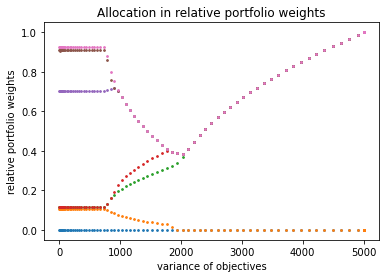

In [23]:
weights_optimal_list_cumulative = []
for i in range(N_assets):
    temp = np.zeros(np.array(weights_optimal_list).shape[0])
    for j in range(i):
        temp += np.array(weights_optimal_list)[:,j]
    weights_optimal_list_cumulative.append(temp)
#print(np.array(weights_optimal_list_cumulative).T)
for i in range(N_assets):
    plt.scatter(risk, np.array(weights_optimal_list_cumulative).T[:,i], s= 3)
plt.title('Allocation in relative portfolio weights')
plt.ylabel('relative portfolio weights')
plt.xlabel('variance of objectives')

Text(0.5, 0, 'variance of objectives')

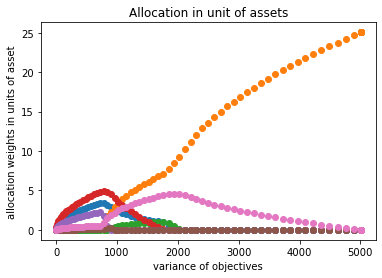

In [24]:
for i in range(N_assets):
    plt.scatter(risk, np.array(α_optimal_list)[:,i])
plt.title('Allocation in unit of assets')
plt.ylabel('allocation weights in units of asset')
plt.xlabel('variance of objectives')

Text(0.5, 0, 'variance of objectives')

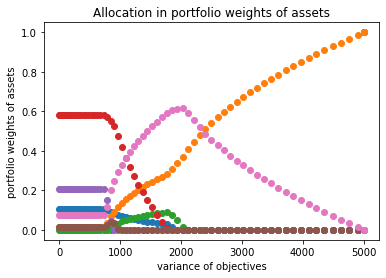

In [25]:
for i in range(N_assets):
    plt.scatter(risk, np.array(weights_optimal_list)[:,i])
plt.title('Allocation in portfolio weights of assets')
plt.ylabel('portfolio weights of assets')
plt.xlabel('variance of objectives')

It's clearly evident that as the allowed variance (risk) increases, the allocation on the efficient frontier tends to converge towards a corner solution. This outcome should be expected since we imposed additional constraints on the classical MVO framework (e.g. long-only). Such optimization problems often have a high likelihood of finding their maximizers/minimizers at the boundary.

Text(0, 0.5, 'mean of objective')

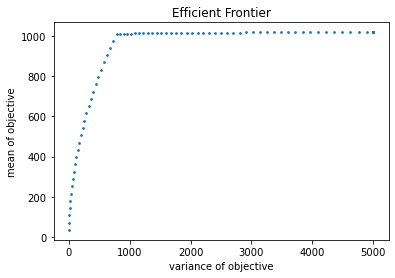

In [26]:
fig = plt.figure()
plt.scatter(np.array(risk), reward,s =3)
plt.title('Efficient Frontier')
plt.xlabel('variance of objective')
plt.ylabel('mean of objective')

It's easy to see that this efficient frontier looks different from the one we generated using fictional data in the section about classical MVO. This is because the various constraints we impose on the optimization process distort the behavior of the optimal allocation, resulting in a steep increase at first which then becomes flat afterwards.


# Determine the optimal allocation using the Index of Satisfaction $\mathcal{S}(\alpha)$


We rank the levels of satisfaction provided by the mean-variance efficient portfolios:
$$
i^* \equiv \underset{i}{\operatorname{argmax}}\left\{\widetilde{\mathcal{S}}\left(\boldsymbol{\alpha}^{(i)}\right)\right\}
$$
Finally, we determine the optimal allocation:
$$
\boldsymbol{\alpha}^* \equiv \boldsymbol{\alpha}^{\left(i^*\right)}
$$

In [27]:
np.argmax(S_α_list)

73

In [28]:
final_optimal_allocation = α_optimal_list[np.argmax(S_α_list)]
final_optimal_allocation

array([1.20876438e-07, 2.50629700e+01, 5.43436769e-08, 1.77990956e-08,
       1.63586140e-08, 7.95646144e-09, 2.15379720e-07])

## Determine the profit and the final wealth attained by holding this optimal allocation

In [29]:
# Specify the start of this investment and the end of this investment
investment_start_date = date_end_estimation
investment_end_date = investment_start_date + 3*timedelta(weeks=1)

# Prices at the beginning of this invesment and at the end of this investment
price_current = df_data[df_data.index==investment_start_date].values.squeeze()
price_investment_horizon = df_data[df_data.index==investment_end_date].values.squeeze()

# Compute the PnL generated by this allocation and the corresponding final wealth
PnL = final_optimal_allocation@(price_investment_horizon-price_current)
final_wealth = initial_wealth + PnL
PnL, final_wealth

(49.85030412202298, 1049.850304122023)

# Aggregate all processes, and let's simulate investment results (backtesting)

In [30]:
def allocation_scheme(df_data=None, # all of the data
                      initial_wealth=None,
                      τ_estimate=1, # estimation horizon
                      τ_horizon=3,
                      index_of_satisfaction='certainty_equivalent', # need work
                      date_start_estimation = pd.to_datetime('2012-01-09'),  # first considered date
                      date_end_estimation = pd.to_datetime('2017-01-02'),  # last date for estimation as well as the current time T
                      estimator='sample',
                      v_inf=1,
                      v_sup=100,
                      v_step=1,
                      N_MC=100 # number of iterations for Monte-Carlo
                     ):
    print(date_end_estimation)
    N_assets = df_data.shape[1]

    # market data for esimation period: \tilde{t} to T
    Market_data_estimate = df_data[(df_data.index >= date_start_estimation) & (df_data.index <= date_end_estimation)].values

    # Prices of asset at current time T
    P_T = Market_data_estimate[-1:]
    
    # transaction cost
    D = np.eye(N_assets)*0.001
    
    # Get market invariants for each asset
    invariants = np.diff(np.log(Market_data_estimate), axis=0)
    
    # estimate sample mean and sample covariance
    μ_X, Σ_X = cal_mean_cov(invariants)
    
    # Project the invariants to the investment horizon
    μ_X_invest_horizon = (τ_horizon/τ_estimate)*μ_X
    Σ_X_invest_horizon = (τ_horizon/τ_estimate)*Σ_X
    
    # Construct appropriate \gamma and \epsilon for the given type of assets
    γ=np.log(P_T)

    E=np.diagflat(np.ones(N_assets))
    
    # Project the investment horizon invariants to prices of assets at investment horizon
    # Notice: the prices of assets at investment horizon P_{T+τ} ~ logNormal(μ_P_logN, Σ_P_logN)
    μ_P_logN=(γ+E@μ_X_invest_horizon).squeeze()
    Σ_P_logN=E@Σ_X_invest_horizon@E

    # Find the mean and covariance matrix for P_{T+τ}
    μ_P = np.exp( μ_P_logN + 0.5*Σ_P_logN.diagonal() )
    #print(μ_P.shape)
    Σ_P = np.zeros((N_assets, N_assets))
    for i in range(N_assets):
        for j in range(N_assets):
            Σ_P[i,j] = np.exp(μ_P_logN[i]+μ_P_logN[j]+0.5*(Σ_P_logN[i,i]+Σ_P_logN[j,j]))*(np.exp(Σ_P_logN[i,j])-1)
            
    
    ####################Optimization
    reward = []
    risk = []
    α_optimal_list = []
    weights_optimal_list = []
    S_α_list=[]

    for target_variances_i in np.arange(v_inf, v_sup, v_step):

        ######## Set objective coefficient c
        c_objective= cvxopt.matrix(-μ_P.T)
        
        ######## Set Constriants
        # Linear (Long-only) Constraint
        G_0 = cvxopt.matrix(-np.eye(N_assets))
        h_0 = cvxopt.matrix(np.zeros(N_assets).reshape(-1,1))

        # Quadratic (Risk) Constraint
        L_transpose_Σ=np.linalg.cholesky(Σ_P)
        G_1 = cvxopt.matrix(np.r_[np.zeros(N_assets).reshape(1,-1), -L_transpose_Σ.T])
        h_1 = cvxopt.matrix(np.r_[np.array([target_variances_i]).reshape(-1,1), np.zeros(N_assets).reshape(-1,1)])

        # Quadratic (Budget) Constraint
        L_transpose_D=np.linalg.cholesky(D)
        G_2 = cvxopt.matrix(np.r_[P_T.reshape(1,-1), -L_transpose_D.T])
        h_2 = cvxopt.matrix(np.r_[np.array([initial_wealth]).reshape(-1,1), np.zeros(N_assets).reshape(-1,1)])

        # Aggregate all the constraints that are not componentwise vector inequalities,i.e., all constraints except G_0, h_0
        G = [G_1, G_2]
        h = [h_1, h_2]
        
        ######## Solve for optimal result
        cvxopt.solvers.options['show_progress'] = False
        α_optimal = np.array(cvxopt.solvers.socp(c=c_objective, Gl = G_0, hl = h_0, Gq = G, hq = h)['x']).squeeze()
        α_optimal_list.append(α_optimal)
        #print('α_optimal',α_optimal)
        w_optimal = np.diagflat(α_optimal)@P_T.T/(P_T@α_optimal)
        weights_optimal_list.append(w_optimal)

        reward.append(α_optimal@μ_P.squeeze())
        risk.append(α_optimal@Σ_P@α_optimal)
        
        S_α_list.append(certainty_equivalent(-9, α_optimal,μ_P_logN,Σ_P_logN, N_MC))

    return α_optimal_list[np.argmax(S_α_list)] # optimal allocation

### Construct a DataFrame to document our PnL

In [31]:
df_investing = pd.DataFrame(index=df_data.index, columns=['MVO'])
df_investing = df_investing[(df_investing.index >= date_end_estimation)]
# df_investing

In [32]:
df_investing['MVO'][0]=1000

for i in range(0,310,3):
    initial_wealth=df_investing['MVO'][i]
    print('initial wealth is: ', initial_wealth)
    end_estimation_date = pd.to_datetime('2017-01-02') + i*timedelta(weeks=1)
    
    α_optimal_allocation = allocation_scheme(df_data=df_data, # all of the data
                                             initial_wealth=initial_wealth,
                                             τ_estimate=1, # estimation horizon
                                             τ_horizon=3,
                                             index_of_satisfaction='certainty_equivalent', 
                                             date_start_estimation = pd.to_datetime('2012-01-01'),  # first considered date
                                             date_end_estimation = end_estimation_date,  # last date for estimation as well as the current time T
                                             estimator='sample',
                                             v_inf=1,
                                             v_sup=100,
                                             v_step=1,
                                             N_MC=100 # number of iterations for Monte-Carlo
                                             )
    #print('α_optimal_allocation is: ', α_optimal_allocation)
    ################# Calculate the PnL generated by holding the optimal portfolio
    # current (buy-in) price
    price_current=df_data[df_data.index==end_estimation_date].values.squeeze()
    
    # investment horizon (sell-off) price
    price_investment_horizon = df_data[df_data.index==end_estimation_date+ 3*timedelta(weeks=1)].values.squeeze()
    
    # PnL generated by holding the optimal portfolio
    PnL= α_optimal_allocation@(price_investment_horizon-price_current)
    
    # update your absolute wealth
    updated_wealth = initial_wealth + PnL
    print('updated_wealth is: ', updated_wealth)
    df_investing['MVO'][i+3] = updated_wealth

initial wealth is:  1000
2017-01-02 00:00:00
updated_wealth is:  1049.9358819817
initial wealth is:  1049.9358819817
2017-01-23 00:00:00
updated_wealth is:  1061.6101740974907
initial wealth is:  1061.6101740974907
2017-02-13 00:00:00
updated_wealth is:  1070.8868198046846
initial wealth is:  1070.8868198046846
2017-03-06 00:00:00
updated_wealth is:  1113.667400887829
initial wealth is:  1113.667400887829
2017-03-27 00:00:00
updated_wealth is:  1128.718414092199
initial wealth is:  1128.718414092199
2017-04-17 00:00:00
updated_wealth is:  1207.576414095243
initial wealth is:  1207.576414095243
2017-05-08 00:00:00
updated_wealth is:  1264.541848356892
initial wealth is:  1264.541848356892
2017-05-29 00:00:00
updated_wealth is:  1260.7885524603746
initial wealth is:  1260.7885524603746
2017-06-19 00:00:00
updated_wealth is:  1266.2969180901744
initial wealth is:  1266.2969180901744
2017-07-10 00:00:00
updated_wealth is:  1256.9601510812026
initial wealth is:  1256.9601510812026
2017-07-3

In [33]:
df_result=df_investing.dropna().copy()

In [34]:
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_rows', 10)
df_result

,MVO
Date,
2017-01-02,1000
2017-01-23,1049.935882
2017-02-13,1061.610174
2017-03-06,1070.88682
2017-03-27,1113.667401
2017-04-17,1128.718414
2017-05-08,1207.576414
2017-05-29,1264.541848
2017-06-19,1260.788552


<AxesSubplot:xlabel='Date'>

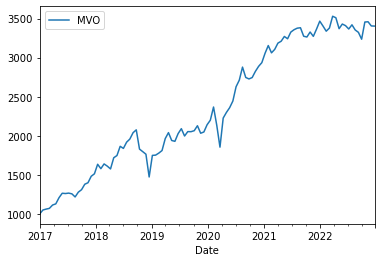

In [35]:
df_result.plot()